# 4.4.1
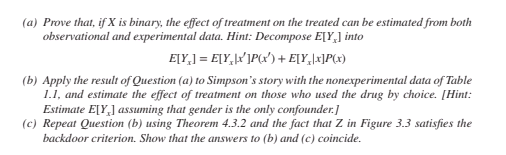

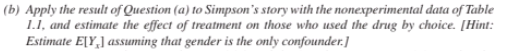

(a) See Richard's solution in `2021-03-14--exercise 4.3.2.ipynb`.

(b)
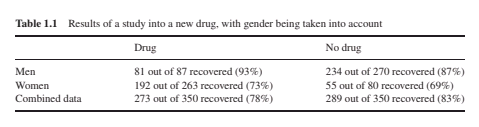

In [39]:
from typing import NamedTuple

class Features(NamedTuple):
    gender: int  # 0=male, 1=female
    drug: int  # 0=no drug, 1=drug
    recovery: int  # 0=not recovered

F = Features
SIMPSON_JOINT_COUNTS = {
    F(0, 1, 0): 87-81,     # male, drug, not recoverd.
    F(0, 1, 1): 81,        # male, drug, recovered.
    F(1, 1, 0): 263-192,   # female, drug, not recovered.
    F(1, 1, 1): 192,       # female, drug, recovered.
    F(0, 0, 0): 270 - 234, # male, no drug, not recovered.
    F(0, 0, 1): 234,       # male, no drug, recovered.
    F(1, 0, 0): 80 - 55,   # female, no drug, not recovered.
    F(1, 0, 1): 55,        # female, drug, recovered.
}


TOTAL = sum(SIMPSON_JOINT_COUNTS.values())
TABLE_1_1 = {k: count / TOTAL for k, count in SIMPSON_JOINT_COUNTS.items()}

from typing import *
from collections import defaultdict
def P(*variables: List[str], joint_dist=TABLE_1_1, **given):
    """
    e.g. P("sprinkler", "slippery", wet=0, season=1) = P(sprinkler, slippery|wet=0, season=1)
    
    Returns a joint distribution on the list of variables, given that `given` is the case.
    """
    Event = NamedTuple('Event', [(variable, Any) for variable in variables])
    p_given = 0.0
    conditional_dist = defaultdict(float)
    for event, prob in joint_dist.items():
        if all(getattr(event, k) == v for k, v in given.items()):
            p_given += prob
            c = Event(*[getattr(event, var) for var in variables])
            conditional_dist[c] += prob
    return {
        c: prob / p_given for c, prob in conditional_dist.items()
    }

# Should match the the last row:
{event: prob * TOTAL for event, prob in P("drug", "recovery").items()}

{Event(drug=1, recovery=0): 77.0,
 Event(drug=1, recovery=1): 273.0,
 Event(drug=0, recovery=0): 60.99999999999999,
 Event(drug=0, recovery=1): 289.0}

Goal is to "estimate the effect of treatment on those who used the drug by choice" (hint: assume gender is the only confounder). IOW, we have the graph:
```
       Z=Gender
       |       \
       |        \
       |         \
       ↓          ↘
     X=Drug------->Y=Recovery
```
From Richard's formula from part (a), our goal is to estimate $E[Y|do(X=0)]$. Since Z=gender satisfies the backdoor criterion for X, Y, we can use the adjustment formula (page 57):
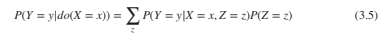

To compute the probabilities. Note also that _for binary variables_, expectation and probability are closely related. For any binary variable $V$, we have the following:
$$E[V] = \sum_{v\in\{0, 1\}} P(V=v)\cdot v = P(V=0)\cdot 0 + P(V=1)\cdot 1 = P(V=1) = 1-P(V=0) $$

Thus $P(Y=1|do(X=0))=E[Y|do(X=0)]$, which we'll now compute with the adjustment formula:

In [40]:
gender_probs = P("gender")
E_Y_given_do_X_0 =   P("recovery", drug=0, gender=0)[(1,)] * gender_probs[(0, )] \
                   + P("recovery", drug=0, gender=1)[(1,)] * gender_probs[(1, )]
print(f"{E_Y_given_do_X_0=}")

E_Y_given_do_X_0=0.778875


Recall Richard's solution from part (a):
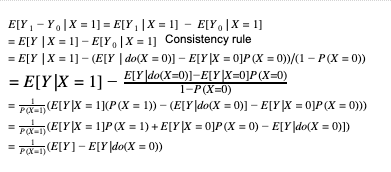

In [54]:
P_X_EQUALS_1 = P("drug")[(1, )]
print(f"{P_X_EQUALS_1=}")
E_Y = P("recovery")[(1, )]
ETT = (1 / P_X_EQUALS_1) * (E_Y - E_Y_given_do_X_0)
print(f"{ETT=}")

P_X_EQUALS_1=0.5
ETT=0.047964285714285904


(c) Goal is to use theorem 4.3.1 to compute the same thing, and we should end up with the same value:
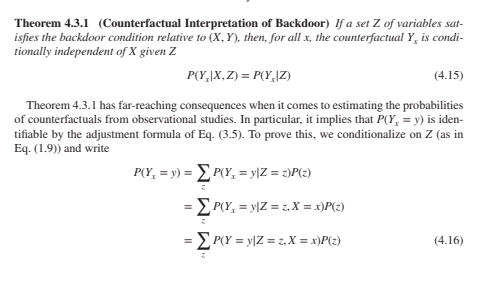

Therefore, we can write

$$\begin{aligned}
    ETT &= E[Y_1 - Y_0|X=1] \\
        &= E[Y_1|X=1] - E[Y_0|X=1] \\
        &= E[Y|X=1] - E[Y_0|X=1] \qquad\textrm{by consistency}\\
        &= P(Y=1|X=1) - P(Y_0=1|X=1)\qquad\textrm{by the binary variable expectation note above}\\
        &= P(Y=1|X=1) - \sum_{z\in\{0, 1\}} P(Y=1|X=0, Z=z)P(z|X=1) \qquad\textrm{by 4.21}\\
\end{aligned}$$

We can compute these from the joint distribution above:

In [64]:
ETT_4_3_1 = (
    P("recovery", drug=1)[(1, )]
    - (  P("recovery", drug=0, gender=0)[(1, )] * P("gender", drug=1)[(0, )]
       + P("recovery", drug=0, gender=1)[(1, )] * P("gender", drug=1)[(1, )])
)
print(f"{ETT_4_3_1=}")

ETT_4_3_1=0.04796428571428579


In [62]:
print(f'{P("gender", drug=0)=}, {87/350=}, {263/350=}')


P("gender", drug=0)={Event(gender=0): 0.7714285714285715, Event(gender=1): 0.22857142857142856}, 87/350=0.24857142857142858, 263/350=0.7514285714285714


# 4.4.2

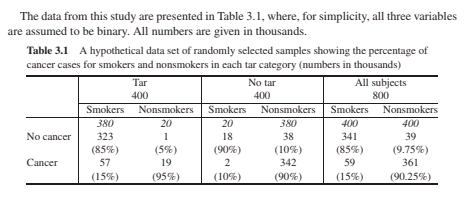

In [12]:
from typing import NamedTuple

class Features(NamedTuple):
    tar: bool
    smoker: bool
    cancer: bool

F = Features
JOINT_COUNTS = {
    # Column 1:
    F(1, 1, 0): 323,
    F(1, 1, 1): 57,
    # Column 2:
    F(1, 0, 0): 1,
    F(1, 0, 1): 19,
    # Column 3:
    F(0, 1, 0): 18,
    F(0, 1, 1): 2,
    # Column 4:
    F(0, 0, 0): 38,
    F(0, 0, 1): 342,
    # Column 5/6: Aggregate data from previous..
}
TOTAL = sum(JOINT_COUNTS.values())
TABLE_3_1 = {k: count / TOTAL for k, count in JOINT_COUNTS.items()}

from typing import *
from collections import defaultdict
def P(*variables: List[str], joint_dist=TABLE_3_1, **given):
    """
    e.g. P("sprinkler", "slippery", wet=0, season=1) = P(sprinkler, slippery|wet=0, season=1)
    
    Returns a joint distribution on the list of variables, given that `given` is the case.
    """
    Event = NamedTuple('Event', [(variable, Any) for variable in variables])
    p_given = 0.0
    conditional_dist = defaultdict(float)
    for event, prob in joint_dist.items():
        if all(getattr(event, k) == v for k, v in given.items()):
            p_given += prob
            c = Event(*[getattr(event, var) for var in variables])
            conditional_dist[c] += prob
    return {
        c: prob / p_given for c, prob in conditional_dist.items()
    }

# Should match the the last two columns:
{event: prob * TOTAL for event, prob in P("smoker", "cancer").items()}

{Event(smoker=1, cancer=0): 341.00000000000006,
 Event(smoker=1, cancer=1): 59.00000000000001,
 Event(smoker=0, cancer=0): 39.00000000000001,
 Event(smoker=0, cancer=1): 361.00000000000006}

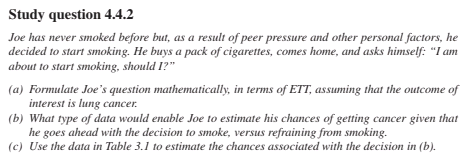

Here we assume the causal model from figure 3.10(b):
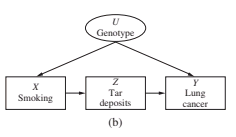


#### Can we use the equations on page 109?

Maybe use the front-door criterion?


From page 68, we have the following (using the front-door criterion):
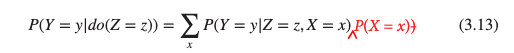
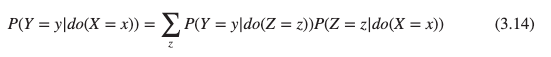
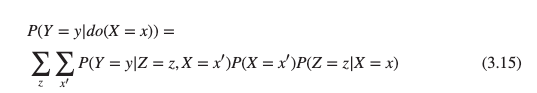

<hr>

Recall that:
\begin{aligned}
    ETT &= E[Y_1 - Y_0|X=1] \\
        &= E[Y_1|X=1] - E[Y_0|X=1] \\
        &= E[Y|X=1] -  E[Y_0|X=1] \qquad \textrm{by the consistency rule (eqn 4.6)} \\
\end{aligned}

The first term can be estimated from the joint probability distribution above, and by noting that expectation is equal to the probability for 0-1 binary variables:

In [19]:
P("cancer", smoker=1)

{Event(cancer=0): 0.8525, Event(cancer=1): 0.1475}

So we need to compute $E[Y_0|X=1]$, which the book claims we can do (page 109, last sentence before exercises).



In [ ]:
def scalar_prob(joint_dist=TABLE_3_1, **givens):
    """
    Returns the probability of the given assignments as a number.
    """
    # An empty list of variables yields a "joint distribution" like {Event(): 1.0}
    [prob] = P(*[], **givens, joint_dist=joint_dist).values()
    return prob

def front_door_formula(joint_dist=TABLE_3_1):
    # X: smoking, Z: tar, Y: cancer
    

P_cancer_given_do_smoker = 